In [49]:
#standard
import numpy as np
np.random.seed(1) #fix seed for notebook
import pandas as pd
import scipy
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

#ML
from xgboost import plot_importance, plot_tree
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [8]:
def pinball_loss(df_true, df_pred):
    timestep_loss=0
    for j in range(df_true.shape[0]):

        for i in range(99):#cycles through 99 quantiles
            tl=df_true[j] #true load for timestep
            qlp=df_pred.iloc[j,i] #quantile load prediction for timestep
            if(tl<qlp):
                timestep_loss=timestep_loss+(1-(i/100))*(qlp-tl)
            if(tl>=qlp):
                timestep_loss=timestep_loss+(i/100)*(tl-qlp)

    return timestep_loss/(99*results.shape[0])

In [2]:
def create_features(df, kind=None, label=None):
    """
    Creates time series features from datetime index
    label=predicted target
    Can be used for creating features for load
    or weather model construction, by setting kind to 
    load
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['weekday'] = (df['date'].dt.dayofweek // 5 == 1).astype(int)
    if(kind=='load'):
        X = df[['weekday', 'year', 'dayofyear','hour',
                'month','dayofweek','quarter','dayofmonth', 'weekofyear','temp']]
#         X = df[['hour','dayofweek','quarter','month','year',
#            'dayofyear','dayofmonth','weekofyear','weekday',]]
    else:
        X = df[['weekday', 'year', 'dayofyear','hour',
        'month','dayofweek','quarter','dayofmonth', 'weekofyear']]
#         X = df[['hour','dayofweek','quarter','month','year',
#            'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [116]:
def predict_data(pred_task_number,n_estimators, metrics=None):
    """
    Enter what number task you want to predict.
    Returns full data set with predicted values included
    Also returns the length of the predicted 
    """
    full_data=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task 1/L1-train.csv')
    task2=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task 2/L2-train.csv')
    full_data=pd.concat([full_data,task2], ignore_index=True)
    predicted_size=task2.shape[0]
    if(pred_task_number > 2):
        for i in range(3,pred_task_number+1):
            temp=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task {}/L{}-train.csv'.format(i,i))
            full_data=pd.concat([full_data, temp], ignore_index=True)
            predicted_size=temp.shape[0] #nrows of predictied df
    ps=predicted_size

    nrows=full_data.shape[0]
    #generate date index for data
    dti = pd.date_range('2001-01-01 01:00', periods=nrows, freq='H')
    full_data['Date']=dti
    full_data=full_data.set_index('Date')

    #true load values
    results=full_data[dti[dti.shape[0]-ps]:]
    results=pd.DataFrame({'True_Load':results.LOAD.values}, index=results.index.copy())
    results #true load values to be compared to

    #drop the true values for model construction
    full_data.drop(full_data.tail(ps).index, inplace=True)

    #weather matrix
    weather=full_data.drop(['ZONEID','TIMESTAMP','LOAD'], axis=1)
    weather_sd=weather.std(axis=1)*3
    dti_w = pd.date_range('2001-01-01 01:00', periods=nrows-ps, freq='H')
    weather_data=pd.DataFrame({'Avg_Temp':weather.mean(axis=1).values,
                               'Low_Temp':weather.mean(axis=1).values-weather_sd,
                               'High_Temp':weather.mean(axis=1).values+weather_sd},index=dti_w)

    #split weather data into train, test
    split_date = '1-1-2008'
    dfw_train = weather_data.loc[weather_data.index <= split_date].copy()
    dfw_test = weather_data.loc[weather_data.index > split_date].copy()



    #grab (Avg,Low, High)train,test features, only time dependent
    Xw_train, yw_train = create_features(dfw_train, label='Avg_Temp')
    Xw_test, yw_test = create_features(dfw_test, label='Avg_Temp')

    low_Xw_train, low_yw_train = create_features(dfw_train, label='Low_Temp')
    low_Xw_test, low_yw_test = create_features(dfw_test, label='Low_Temp')

    high_Xw_train, high_yw_train = create_features(dfw_train, label='High_Temp')
    high_Xw_test, high_yw_test = create_features(dfw_test, label='High_Temp')

    #fit weather Avg data model
    Avgregw = xgb.XGBRegressor(n_estimators=n_estimators)
    Avgregw.fit(Xw_train, yw_train,
            eval_set=[(Xw_train, yw_train), (Xw_test, yw_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train
    #fit weather Low data model
    Lowregw = xgb.XGBRegressor(n_estimators=n_estimators)
    Lowregw.fit(low_Xw_train, low_yw_train,
            eval_set=[(low_Xw_train, low_yw_train), (low_Xw_test, low_yw_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train

    #fit weather High data model
    Highregw = xgb.XGBRegressor(n_estimators=n_estimators)
    Highregw.fit(high_Xw_train, high_yw_train,
            eval_set=[(high_Xw_train, high_yw_train), (high_Xw_test, high_yw_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train


    #create time interval for predition for weather temps
    dti_p=dti[dti.shape[0]-ps:]
    pt=pd.DataFrame(data=None, index=dti_p)
    prediction_tf=create_features(pt)
    prediction_tf

    #predict (Avg, High, Low) weather temps for predicted task
    weather_pred=pd.DataFrame()
    weather_pred['Pred_Avg_Temp']=Avgregw.predict(prediction_tf)
    weather_pred['Pred_High_Temp']=Highregw.predict(prediction_tf)
    weather_pred['Pred_Low_Temp']=Lowregw.predict(prediction_tf)

    #drop nan values from full_data for load model
    load_data=full_data.dropna()
    #create load data with temp to fit model
    load_length=load_data.shape[0]
    load_values=load_data.LOAD.values
    w=load_data.drop(['ZONEID', 'TIMESTAMP','LOAD'],axis=1)
    mw=w.mean(axis=1)
    dti_l = pd.date_range('2005-01-01 01:00', periods=load_length, freq='H')
    load_df=pd.DataFrame({'LOAD': load_values,'temp':mw.values, 'index': dti_l})
    load_df=load_df.set_index('index')

    #split data for train/test
    split_date = '1-1-2009'
    dfl_train = load_df.loc[load_df.index <= split_date].copy()
    dfl_test = load_df.loc[load_df.index > split_date].copy()

    #create features for load model
    Xl_train, yl_train = create_features(dfl_train,kind='load', label='LOAD')
    Xl_test, yl_test = create_features(dfl_test, kind='load',label='LOAD')

    #train load/temp model from all data besides predicted data
    loadreg = xgb.XGBRegressor(n_estimators=n_estimators)
    loadreg.fit(Xl_train, yl_train,
            eval_set=[(Xl_train, yl_train), (Xl_test, yl_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train

    #adds weekday to prediction 
    prediction_tf['weekday'] = (prediction_tf['dayofweek'] // 5 == 1).astype(int)

    #predicts low temp load prediction
    prediction_tf['temp']=weather_pred['Pred_Low_Temp'].values
    results['Pred_Low_Load']=loadreg.predict(prediction_tf)

    #predicts average temp load forecast
    prediction_tf['temp']=weather_pred['Pred_Avg_Temp'].values
    results['Pred_Avg_Load']=loadreg.predict(prediction_tf)

    #predicts high temp load prediction
    prediction_tf['temp']=weather_pred['Pred_High_Temp'].values
    results['Pred_High_Load']=loadreg.predict(prediction_tf)

    #import benchmark data
    benchmark=pd.read_csv('/Users/rrj/Documents/Work Folder/NREL/Load Forecasting/GEFCom2014 Data/Load/Task {}/L{}-benchmark.csv'.format(pred_task_number-1,pred_task_number-1))
    benchmark=benchmark.drop(['ZONEID','TIMESTAMP'],axis=1)
    results['benchmark']=benchmark['0.01'].values
    
    #this creates the data frame to compare the true values
    columns=['0.01']
    x=0.01
    for i in range(98):
        x=round(x+.01,2)
        columns.append('{}'.format(x))
    pin=pd.DataFrame(columns=columns, index=dti_p)
    #adds the quantile values to the dataframe to compare to true values
    for i in range(results.shape[0]):
        a=np.linspace(results['Pred_Low_Load'][i], results['Pred_Avg_Load'][i], num=50)
        b=np.linspace(results['Pred_Avg_Load'][i], results['Pred_High_Load'][i], num=50)
        out_arr2 = np.concatenate((a[1:50], b), axis=None)
        out_arr2.sort(axis=0)
        pin.iloc[i]=out_arr2
    
    pred_mse=mean_squared_error(results['True_Load'],results['Pred_Avg_Load'])
    bench_mse=mean_squared_error(results['True_Load'],results['benchmark'])
    pred_pin=pinball_loss(results['True_Load'], pin)
    bench_pin=pinball_loss(results['True_Load'], benchmark)
    array = np.array(['Task {}'.format(pred_task_number),pred_mse,pred_pin,bench_mse,bench_pin]).reshape(1,5)


    if(pred_task_number==2):
        metric_columns=['Task #', 'Predicted_MSE', 'Predicted_Pinball', 'Benchmark_MSE', 'Benchmark_Pinball']
        metrics=pd.DataFrame(columns=metric_columns,data=array)
        print('Frist time Pred_task_number:',pred_task_number)
    else:
        print('Pred_task_number:',pred_task_number)
        metric_columns=['Task #', 'Predicted_MSE', 'Predicted_Pinball', 'Benchmark_MSE', 'Benchmark_Pinball']
        temp=pd.DataFrame(columns=metric_columns,data=array)
        metrics=metrics.append(temp)

    # Plot the forecast with the actuals
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    results['True_Load'].plot(ax=ax,style='.')
    results['benchmark'].plot(ax=ax,style='-',c='r')

    ax.set_xbound(lower=results.index[0], upper=results.index[-1])
    ax.set_ylim(0, 300)
    ax.fill_between(dti_p, results['Pred_High_Load'], results['Pred_Low_Load'], alpha=.25)
    plot = plt.suptitle('Forecast vs Actuals for between {} and {}'.format(results.index[0],results.index[-1]))
    return metrics

[10:54:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Frist time Pred_task_number: 2
[10:55:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Pred_task_number: 3
[10:55:32] WARNING: s

,Task #,Predicted_MSE,Predicted_Pinball,Benchmark_MSE,Benchmark_Pinball
0,Task 2,170.56724982209627,4.549635567358831,378.7878629032258,7.1979852150538
0,Task 3,509.2835678525045,5.798325481865397,466.27075,7.867569892473161
0,Task 4,4517.887732990396,21.38811609722996,3916.299045698925,24.37271639784961
0,Task 5,2632.834985261693,15.074570611260762,2388.1223521505376,18.748985215053793
0,Task 6,1023.7551213837651,8.718635543096006,2915.3078273809524,20.906594086021546
0,Task 7,806.4127430950895,7.769243965822686,1245.5477150537633,13.214061827957016
0,Task 8,340.91969147134483,4.644301042282544,531.3929861111111,8.046256720430051
0,Task 9,1086.3669210704043,6.934953543747824,943.7524865591397,10.937495967741825
0,Task 10,1008.3827490318157,7.573915796879583,1616.910625,16.605635752688272
0,Task 11,1588.4851599341705,10.063703584298027,1141.1546908602152,13.395797043010694


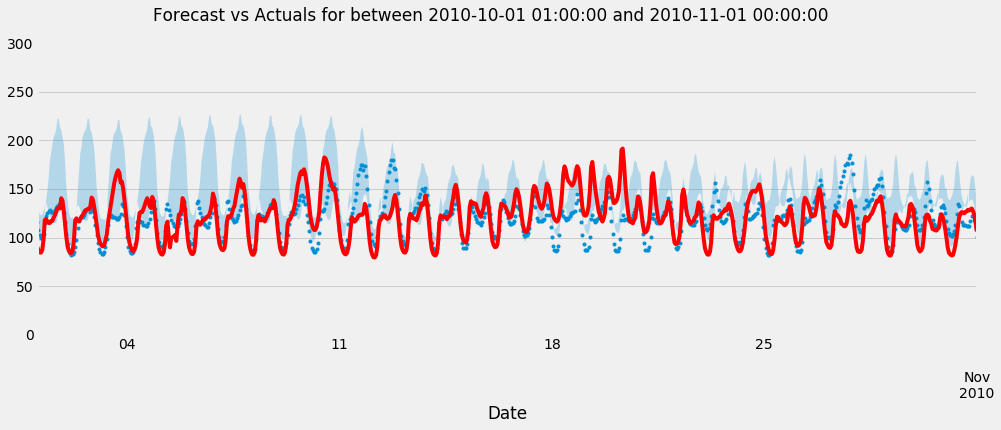

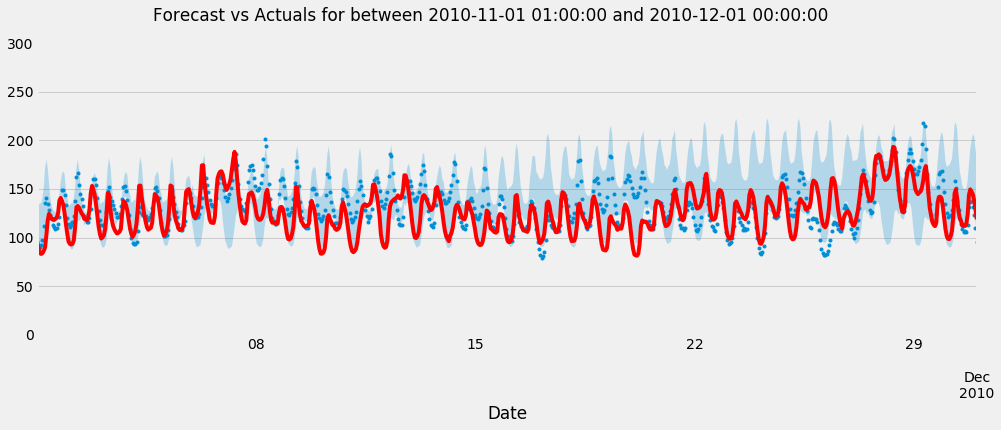

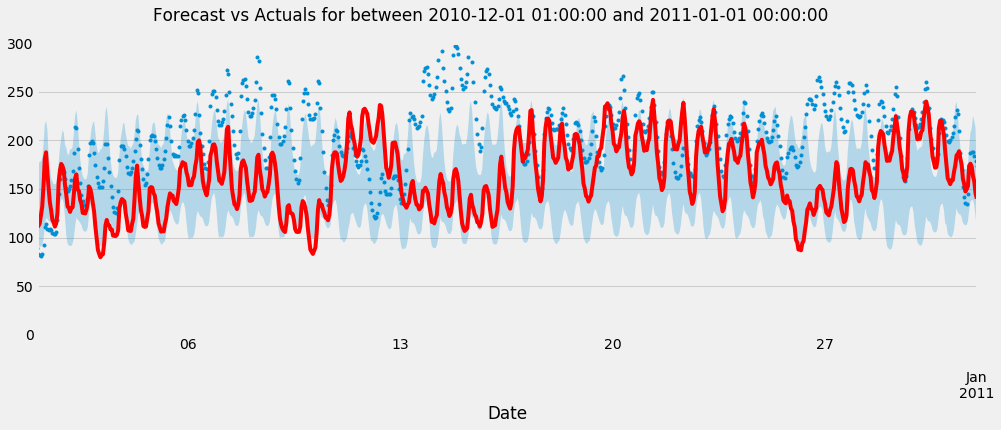

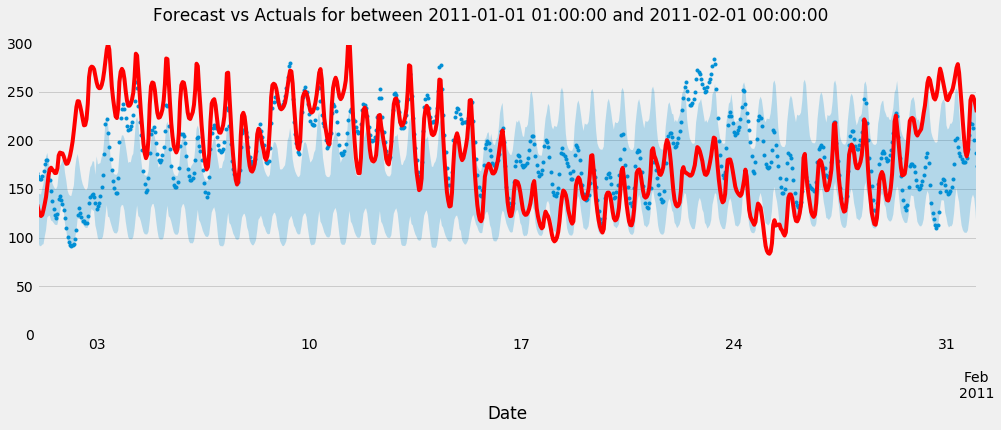

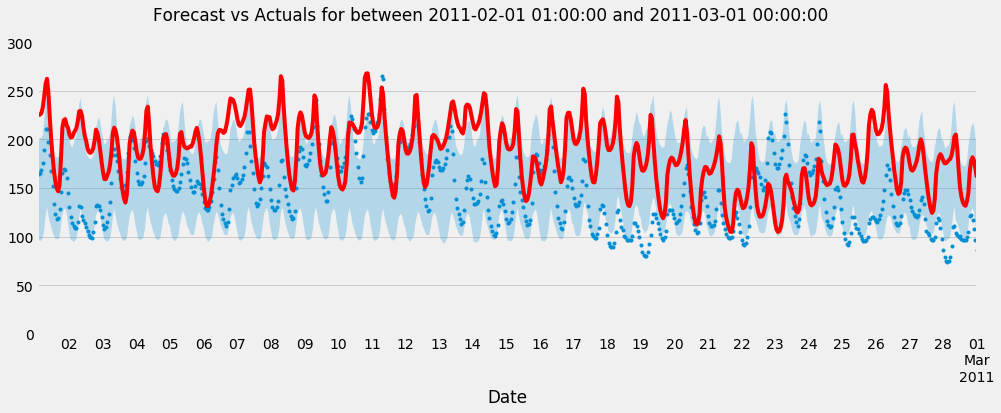

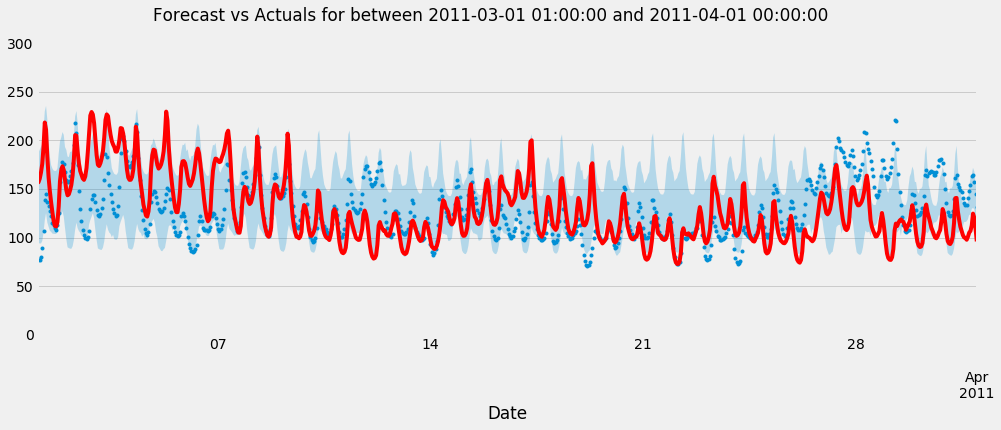

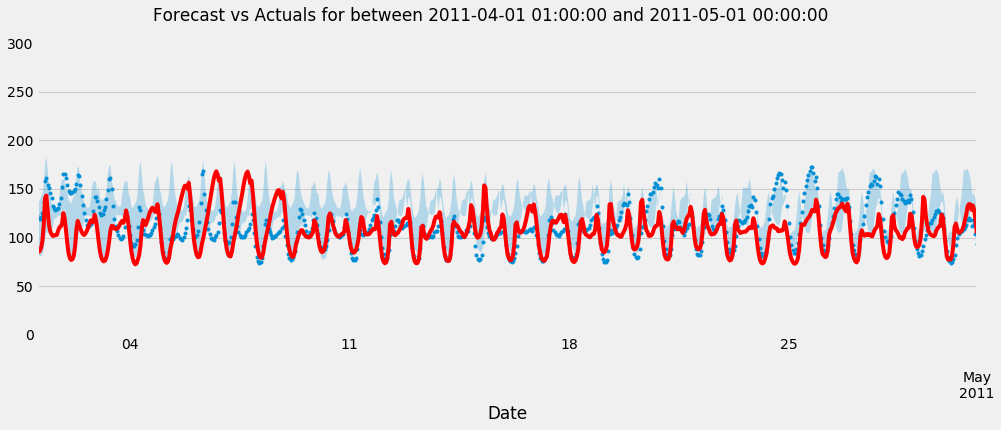

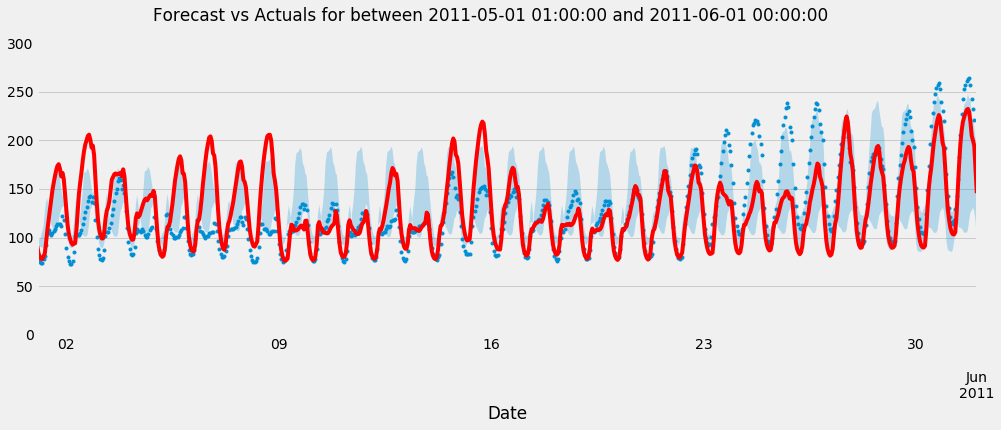

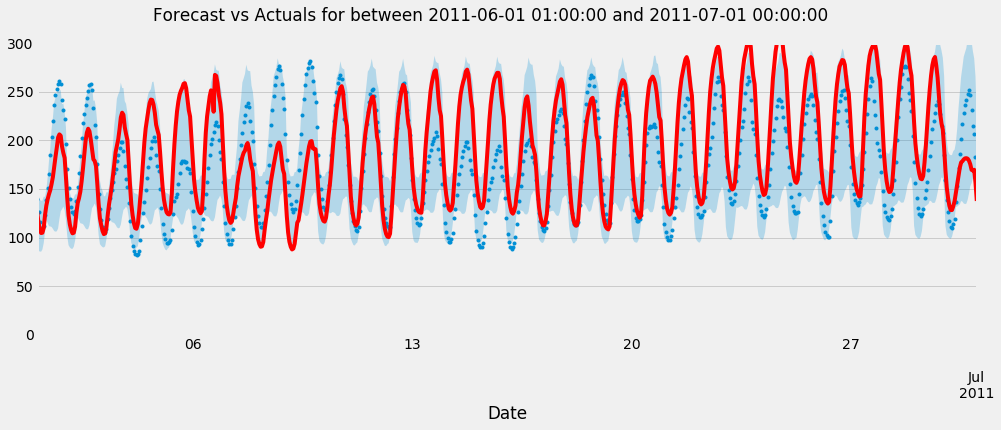

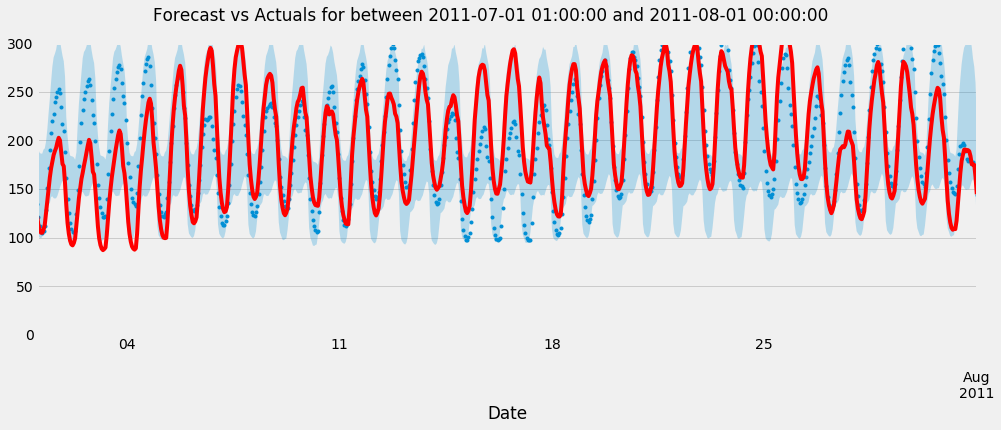

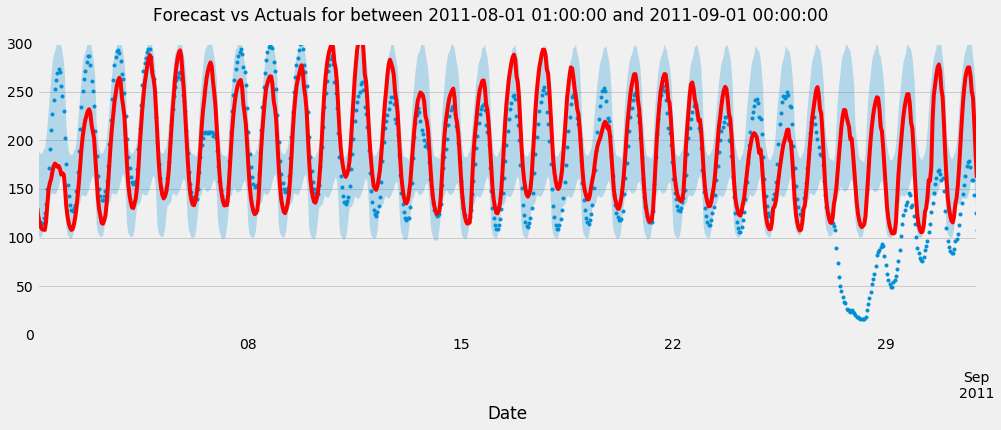

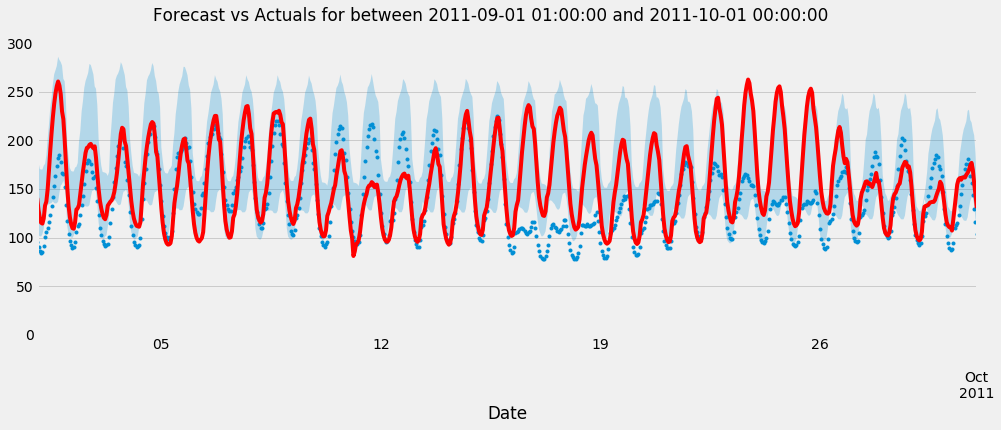

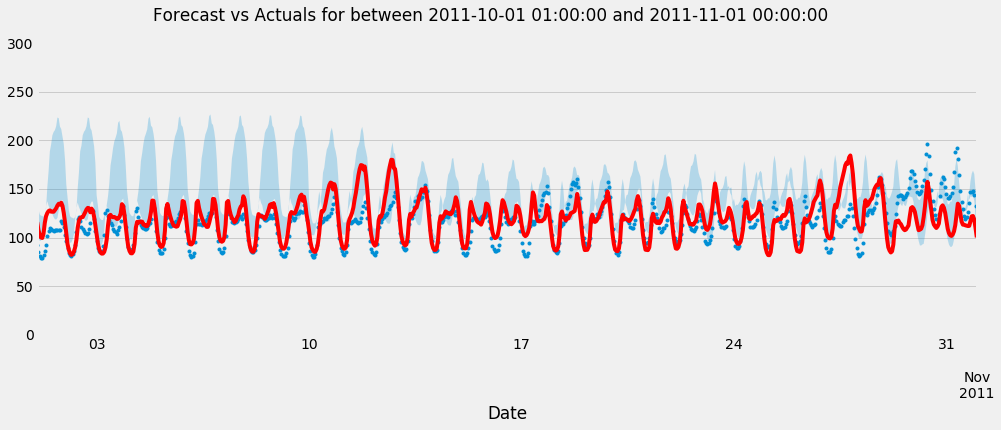

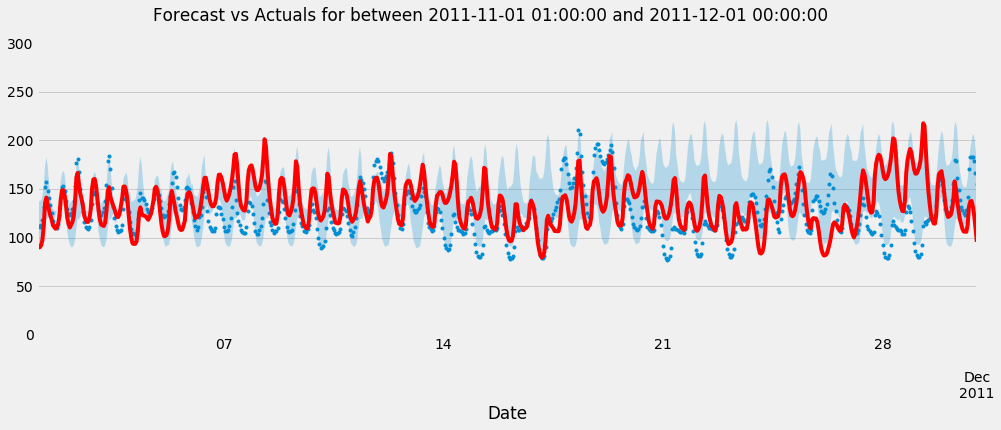

In [118]:

for i in range(2,16):
    if(i==2):
        metrics=predict_data(i,1000)
    else:
        metrics=predict_data(i,1000, metrics=metrics)
metric_columns=['Task #', 'Predicted_MSE', 'Predicted_Pinball', 'Benchmark_MSE', 'Benchmark_Pinball']
total=[]
for columns in metric_columns[1:5]:
    test[columns]= pd.to_numeric(test[columns])
    total.append(test[columns].sum())

array1 = np.array(['Task Totals',total[0],total[1],total[2], total[3]]).reshape(1,5)
metric_columns1=['Task #','Predicted_MSE', 'Predicted_Pinball', 'Benchmark_MSE', 'Benchmark_Pinball']
temp1=pd.DataFrame(columns=metric_columns1,data=array1)
metrics=metrics.append(temp1)
metrics

In [31]:
#this creates the data frame to compare the true values
columns=['0.01']
x=0.01
for i in range(98):
    x=round(x+.01,2)
    columns.append('{}'.format(x))
pin=pd.DataFrame(columns=columns, index=dti_p)
#adds the quantile values to the dataframe to compare to true values
for i in range(results.shape[0]):
    a=np.linspace(results['Pred_Low_Load'][i], results['Pred_Avg_Load'][i], num=50)
    b=np.linspace(results['Pred_Avg_Load'][i], results['Pred_High_Load'][i], num=50)
    out_arr2 = np.concatenate((a[1:50], b), axis=None)
    out_arr2.sort(axis=0)
    pin.iloc[i]=out_arr2

In [32]:
i=1
pred_mse=mean_squared_error(results['True_Load'],results['Pred_Avg_Load'])
bench_mse=mean_squared_error(results['True_Load'],results['benchmark'])
pred_pin=pinball_loss(results['True_Load'], pin)
bench_pin=pinball_loss(results['True_Load'], benchmark)
array = np.array(['Task {}'.format(pred_task_number),pred_mse,pred_pin,bench_mse,bench_pin]).reshape(1,5)


if(i==0):
    metric_columns=['Task #', 'Predicted_MSE', 'Predicted_Pinball', 'Benchmark_MSE', 'Benchmark_Pinball']
    metrics=pd.DataFrame(columns=metric_columns,data=array)
else:
    metric_columns=['Task #', 'Predicted_MSE', 'Predicted_Pinball', 'Benchmark_MSE', 'Benchmark_Pinball']
    temp=pd.DataFrame(columns=metric_columns,data=array)
    metrics=metrics.append(temp)
metrics

,Task #,Predicted_MSE,Predicted_Pinball,Benchmark_MSE,Benchmark_Pinball
0,Task 2,170.56724982209627,4.549635567358831,378.7878629032258,7.1979852150538
0,Task 3,509.2835678525045,5.9916029979275764,466.27075,8.129822222222266
0,Task 4,4517.887732990396,21.38811609722996,3916.299045698925,24.37271639784961


In [67]:
metrics=metrics.set_index('Task #')

In [108]:
test=metrics
test

,Task #,Predicted_MSE,Predicted_Pinball,Benchmark_MSE,Benchmark_Pinball
0,Task 2,170.56724982209627,4.549635567358831,378.7878629032258,7.1979852150538
0,Task 3,509.2835678525045,5.798325481865397,466.27075,7.867569892473161
0,Task 4,4517.887732990396,21.38811609722996,3916.299045698925,24.37271639784961
0,Task 5,2632.834985261693,15.074570611260762,2388.1223521505376,18.748985215053793
0,Task 6,1023.7551213837651,8.718635543096006,2915.3078273809524,20.906594086021546
0,Task 7,806.4127430950895,7.769243965822686,1245.5477150537633,13.214061827957016
0,Task 8,340.91969147134483,4.644301042282544,531.3929861111111,8.046256720430051
0,Task 9,1086.3669210704043,6.934953543747824,943.7524865591397,10.937495967741825
0,Task 10,1008.3827490318157,7.573915796879583,1616.910625,16.605635752688272
0,Task 11,1588.4851599341705,10.063703584298027,1141.1546908602152,13.395797043010694


In [113]:
total=[]
for columns in metric_columns[1:5]:
    test[columns]= pd.to_numeric(test[columns])
    total.append(test[columns].sum())

array1 = np.array(['Task Totals',total[0],total[1],total[2], total[3]]).reshape(1,5)
metric_columns1=['Task #','Predicted_MSE', 'Predicted_Pinball', 'Benchmark_MSE', 'Benchmark_Pinball']
temp1=pd.DataFrame(columns=metric_columns1,data=array1)
metrics=metrics.append(temp1)
metrics

,Task #,Predicted_MSE,Predicted_Pinball,Benchmark_MSE,Benchmark_Pinball
0,Task 2,170.567,4.54964,378.788,7.19799
0,Task 3,509.284,5.79833,466.271,7.86757
0,Task 4,4517.89,21.3881,3916.3,24.3727
0,Task 5,2632.83,15.0746,2388.12,18.749
0,Task 6,1023.76,8.71864,2915.31,20.9066
0,Task 7,806.413,7.76924,1245.55,13.2141
0,Task 8,340.92,4.6443,531.393,8.04626
0,Task 9,1086.37,6.93495,943.752,10.9375
0,Task 10,1008.38,7.57392,1616.91,16.6056
0,Task 11,1588.49,10.0637,1141.15,13.3958


In [111]:
metric_columns[1:5]

['Predicted_MSE', 'Predicted_Pinball', 'Benchmark_MSE', 'Benchmark_Pinball']